# Predicting Player Engagement Using Experience Levels with K-NN Regression


## Introduction
### Background

Running research studies that collect video game player data requires planning and resources. In this project, a research team is studying player behavior on a Minecraft server to better understand how players engage with the game over time. One important aspect of engagement is how many hours a player spends playing on the server. Knowing which players are likely to play more can help researchers estimate server demand, plan resources, and better target recruitment efforts.

By building models that predict playtime based on player characteristics, researchers can forecast which types of players might generate more gameplay data. This can help with making decisions about server capacity, hardware needs, and even which players to focus on when recruiting participants. In this project, I explore whether a player’s experience level can help predict how many hours they will play, using a K-Nearest Neighbors (K-NN) regression approach.

### The Research Question

The broad research question provided by the research team is:

"Which kinds of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts?"

The specific research question I will be answering is:

"Can a player’s experience level be used to predict how many hours they will play on the Minecraft server?"

By answering this question, I hope to help the research team better understand which types of players are likely to spend more time playing. These insights could be useful for planning server resources and prioritizing recruitment of highly engaged players.


### Data Description

Before starting the analysis, we first need to load the necessary R packages that will allow us to work with the data.

- **tidyverse** — for data wrangling, reading files, cleaning variables, and visualizing data.
- **tidymodels** — for building and evaluating classification models later on



In [1]:
library(tidyverse) 
library(tidymodels) 
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Now that the packages are loaded, we can read in our dataset and begin exploring its structure. This will help us better understand the variables, the number of observations, and any potential issues before we build the model.

In [2]:
players_data<-read_csv("players (1).csv")
players_data

n_rows <- nrow(players_data)
n_cols <- ncol(players_data)
n_rows
n_cols


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] 196

[1] 7

### **Data Set Summary**

The `players.csv` dataset contains information about **196 players** and includes **7 columns**. Below is a summary of the key variables:

 **1. Variables Used**

- **experience**: The player’s experience level, recorded as one of five categories: `Beginner`, `Amateur`, `Regular`, `Veteran`, or `Pro`. This variable will be used as the **predictor** in my analysis. I converted this variable into numeric values so that it can be used for regression modeling.

- **played_hours**: The total number of hours each player has spent playing on the Minecraft server. This is the **response variable** I am trying to predict.

**2. Other Variables in the Dataset (Not Used)**

- **subscribe**: Whether the player subscribed to a game newsletter (`TRUE` or `FALSE`). Not used for this analysis.
- **hashedEmail**: An anonymized ID for each player. Not used.
- **name**: The player’s first name. Not used.
- **gender**: The player’s gender. Not used.
- **Age**: The player’s age in years. Not used.

 **3. Rows and Columns**

The dataset contains **196 observations** and **7 columns**.

 **4. Data Issues**

- All missing values have been checked; none were found in the variables used for modeling.
- Variables not related to this research question (such as **name, email, gender, age,** and **subscribe status**) were excluded.


## **Methods & Results**

### **Data Wrangling**

Now that we understand the structure of our dataset, we will first prepared the data for modeling.

Since our research question focuses on predicting `played_hours` using `experience`, we will only be keeping the variables needed for this analysis. The `experience` variable was originally a text category (`Beginner`, `Amateur`, `Regular`, `Veteran`, `Pro`), so we converted it into numeric values (numbered 1–5) to use it as a predictor in the regression model.

We will then select just the two variables we need:
- `exp_num`: the numeric version of experience (predictor)
- `played_hours`: total playtime (response variable)
 

In [3]:
players_data <- read_csv("players (1).csv", show_col_types = FALSE) %>%
  mutate(
    experience = factor(
      experience,
      levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
    ),
    exp_num = as.numeric(experience)
  )

knn_df <- players_data %>%
  select(exp_num, played_hours)
knn_df


exp_num,played_hours
<dbl>,<dbl>
5,30.3
4,3.8
4,0.0
⋮,⋮
2,0.0
2,2.3
5,0.2


### **Exploratory Visualization**

After wrangling, we will create a scatter plot to visualize the relationship between experience level and played hours. This helps us check for patterns and relationships.

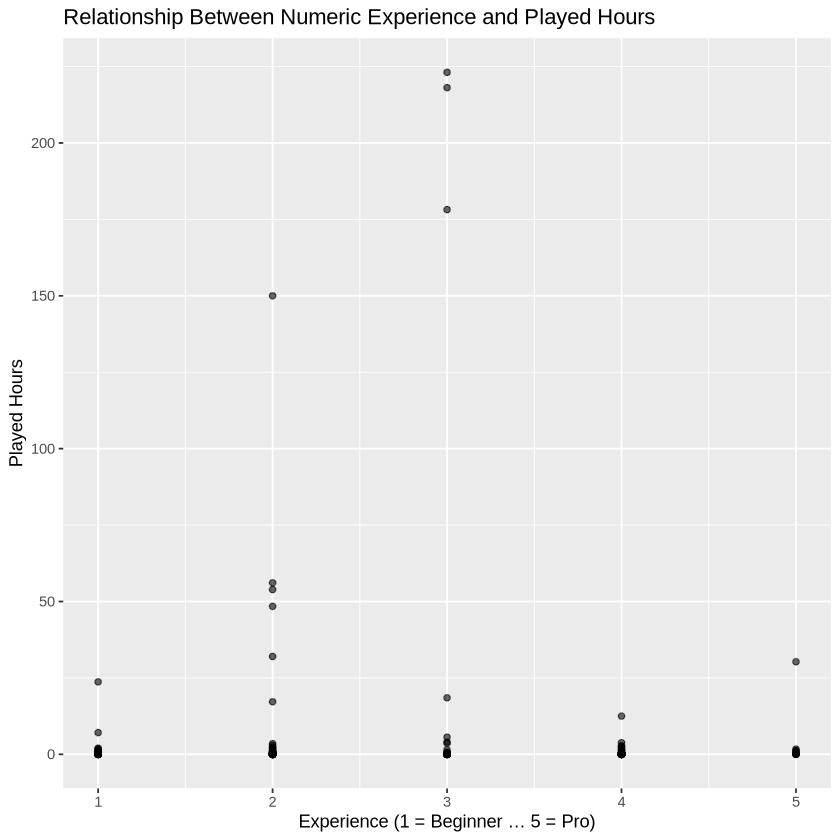

In [4]:
players_data_plot<- ggplot(knn_df, aes(x = exp_num, y = played_hours)) +
  geom_point(alpha = 0.6) +
  labs(
    x     = "Experience (1 = Beginner … 5 = Pro)",
    y     = "Played Hours",
    title = "Relationship Between Numeric Experience and Played Hours"
  )

players_data_plot

### **Exploratory Visualization Interpretation**

From the plot above, we can see that while a few players have very high playtime values at certain experience levels, most players tend to have much lower total playtime, with many points close to zero. This suggests that the relationship between experience and played hours may not follow a perfectly linear pattern.

### **Patterns Observed:**

- Most players across all experience levels have low played hours.
- A small number of players, especially at some experience levels, have very high played hours.
- There is no simple or consistent trend where higher experience always leads to more played hours.
- Overall, the data shows a lot of variability, which is common in real-world datasets.

### **Building the K-Nearest Neighbors (KNN) Model**
In this section, I build a KNN regression model to predict **played_hours** using **experience** as the predictor.

#### **Step 1: Data Splitting & Preprocessing**

I start by splitting the data into training and testing sets. This allows me to evaluate how well the model performs on new, unseen data.

I use 75% of the data for training and keep the remaining 25% for testing.



In [5]:
set.seed(2025)
players_split    <- initial_split(players_data, prop = 0.75)
players_train    <- training(players_split)
players_test     <- testing(players_split)

#### **Step 2: Create Recipe and Model Specification**

Now I will build a recipe to prepare the data for modeling. Since KNN relies on distance-based calculations, I will also center and scale all predictors to make sure they are on the same scale. This prevents one predictor from dominating the distance calculations.


In [6]:
players_recipe <- recipe(played_hours ~ exp_num, data = players_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

#### **Step 3: Model Specification**

Here, I set up the KNN regression model using the kknn engine. Since I don’t know the best value for **k** yet, I have left it open for tuning with the tune function. I will figure out the best **k** later on when I evaluate the model’s performance.


In [7]:
players_spec <- nearest_neighbor(
                  weight_func = "rectangular",
                  neighbors   = tune()
                ) |>
  set_engine("kknn") |>
  set_mode("regression")

#### **Step 4: Cross-validation Setup and Creating the Workflow and Tuning**

Now I will set up 5-fold cross-validation on my training data. This lets me test how well different values of **k** perform without using the test set yet. I will also combine my recipe and model into one workflow.


In [8]:
players_wf <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

In [9]:
players_vfold <- vfold_cv(players_train, v = 5)

#### **Step 6: Tune k**

At this step, I run a grid search to try out different values of **k** from 1 to 50. For each **k**, cross-validation calculates performance using RMSE and R-squared. This helps me find out which value of **k** works best for my data.

In [10]:
grid_vals <- tibble(neighbors = seq(1, 50))

players_results <- players_wf |>
  tune_grid(
    resamples = players_vfold,
    grid      = grid_vals,
    metrics   = metric_set(rmse, rsq)
  ) |>
  collect_metrics()

#### **Step 7: Find the Best k**

Now I select the value of **k** that gives the lowest RMSE from my grid search. This gives me the most accurate model based on my training data.

In [11]:

k_min <- players_results |>
  filter(.metric == "rmse") |>
  slice_min(mean, n = 1) |>
  pull(neighbors)


#### **Step 8: Build and Fit the Final Model**

Now that I have my best **k** value, I rebuild the model using that value. Then I fit this final model to my entire training data, which allows me to make predictions later on.


In [12]:
players_best_spec <- nearest_neighbor(
                       weight_func = "rectangular",
                       neighbors   = k_min
                     ) |>
  set_engine("kknn") |>
  set_mode("regression")

players_best_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_best_spec)

players_best_fit <- players_best_workflow |>
  fit(data = players_train)


#### **Step 9: Evaluate the Model on the Test Set**

Now, I can test my final model on the test data to see how well it performs on unseen data. The main metrics I look at are **RMSE (Root Mean Squared Error)**, **R-squared (R²)**, and **MAE (Mean Absolute Error)**. 


In [13]:
players_summary <- players_best_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.917954619
rsq,standard,0.009806458
mae,standard,4.048979592


From my results, the RMSE is around 21.92, the MAE is around 4.05, and the R² value is very low. This suggests that while my model can capture some patterns, it doesn't explain much of the variation in played hours, which may be due to the real-world variability in how people play.

#### **Step 10: Create New Observations to Predict**

Now that my model is trained, I will now prepare two new observations to test it. I will create two example players: one with **Regular** experience and one with **Pro** experience. I will also convert their experience levels into numeric values so that my model can make predictions on it.


In [14]:
# setting up a new observation

new_players <- tibble(
  experience = factor(
    c("Regular", "Pro"),
    levels  = c("Beginner","Amateur","Regular","Veteran","Pro"),
    ordered = TRUE
  )
) |>
  mutate(exp_num = as.numeric(experience))

new_players

experience,exp_num
<ord>,<dbl>
Regular,3
Pro,5


In [15]:

new_preds <- players_best_fit |>
  predict(new_players) |>
  bind_cols(new_players)

new_preds

.pred,experience,exp_num
<dbl>,<ord>,<dbl>
0,Regular,3
0,Pro,5


As you can see, my model is predicting 0 hours for both the “Regular” and “Pro” players. This may be because the model was tuned to the absolute minimum RMSE, which happened when k = 1. Since k=1 simply takes the single closest neighbor, and that nearest neighbor likely had 0 played hours, the prediction also becomes 0.

To better understand why k=1 came up as the best choice, I will now look at and examine how RMSE changes as k increases. If RMSE stays fairly stable with slightly larger k values, it may make sense to use a larger k to avoid overly relying on just one data point.



#### **Step 11: Visualizing RMSE Across Different k Values**

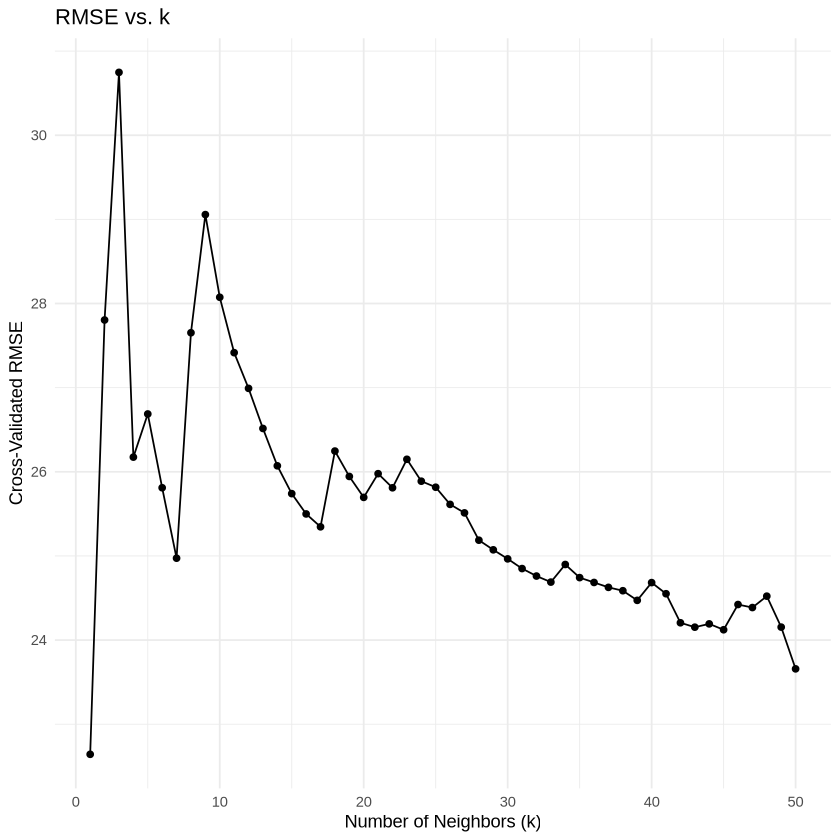

In [16]:
rmse_results <- players_results |>
  filter(.metric == "rmse")

rmse_plot <- ggplot(rmse_results, aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(
    x     = "Number of Neighbors (k)",
    y     = "Cross-Validated RMSE",
    title = "RMSE vs. k"
  ) +
  theme_minimal()

rmse_plot

As we can see, the RMSE values from k = 1 up to around k = 10 are very noisy and bounce around a lot from different RMSE values. This may be one of the reasons why my model was earlier predicting 0 played hours — since small k-values often overfit to the few closest points, which sometimes happened to have 0 hours.

In a 2024 study, Maulana & Roestam used an elbow method for tuning a k-nearest neighbors model when predicting voter turnout. They plotted model error across different k-values and selected a k where the error curve flattened out, instead of just picking the k that gave the absolute lowest error. This helped balance overfitting and underfitting.

Following a similar approach, I look at my own CV-RMSE vs. k plot and notice that after around k = 20, the curve starts to flatten out. Rather than using k = 1 again, I will now test my model using k = 20. This may give a more stable and generalizable model that avoids the extreme predictions seen earlier.

#### **Step 12: Build a New Model Using k = 20**

Since k = 1 was causing zero-only predictions, I will now build a new KNN regression model using k = 20, which was selected based on the CV RMSE elbow point.


In [17]:
players20_spec <- nearest_neighbor(
  weight_func = "rectangular",
  neighbors   = 20
) |>
  set_engine("kknn") |>
  set_mode("regression")

players20_wf <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players20_spec)

#### **Step 12: Evaluate the Model with k = 20**

Now I can evaluate how the model performs on the test data using the updated k value.

In [18]:
players20_fit <- players20_wf |>
  fit(data = players_train)

players20_summary <- players20_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

players20_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.762724676
rsq,standard,0.001454971
mae,standard,8.027142857


After switching to k = 20, the RMSE slightly increased to 22.76, and the MAE also increased compared to when k was 1. The R-squared value remains very low, which suggests that experience alone still does not strongly explain variation in played hours. However, this model avoids the issue of predicting only 0s like before, making it slightly more reasonable for generalization even though the relationship between experience and played hours appears quite weak overall.

#### **Step 13: Make Predictions Using the Final Model**
Now that the model is trained using k = 20, we use it to predict the number of played hours for two new players: one with “Regular” experience and one with “Pro” experience.

In [19]:
players20_preds <- players20_fit |>
  predict(new_players) |>
  bind_cols(new_players)

players20_preds

.pred,experience,exp_num
<dbl>,<ord>,<dbl>
20.565,Regular,3
1.755,Pro,5


After switching to k = 20, the model now predicts 20.6 hours for a Regular player and 1.76 hours for a Pro player. This is a noticeable improvement from before, where the model predicted 0 hours for both. These predictions still may not be perfectly accurate, but they are more reasonable and reflect some variation based on experience level. This suggests that using a higher k helps the model generalize better rather than just memorizing its nearest neighbor.

#### **Why did I choose to use a K-nearest Neighbours regression model?**

I chose K-nearest Neighbours (K-NN) regression because my response variable, `played_hours`, is numeric, and my goal is to predict how many hours a player might play based on their experience level. As the textbook explains, regression is appropriate when the outcome we're predicting is a number, not a category.

K-NN regression is a good fit for this problem because it makes very few assumptions about the relationship between experience and playtime. Instead of forcing the data into a straight line (like linear regression does), K-NN predicts values based on the average of the closest data points (neighbors). This allows it to work well even if the relationship between experience and playtime isn’t perfectly linear, which is something I observed in my data exploration.

Also, the K-NN approach is fairly simple and easy to understand: the model looks at players with similar experience levels to make a prediction. Since my dataset is not very large and the relationship may be non-linear, K-NN regression provides a flexible option that can adapt to patterns in the data.


#### **What assumptions are required to apply the K-nearest Neighbours regression model?**

K-NN regression has fewer strict assumptions compared to some other models, but there are still some important things to keep in mind when using this modle.

- **Similarity matters:** The algorithm assumes that observations that are "close" to each other in predictor space will have similar response values. This means that players with similar experience levels are assumed to have similar played hours.
  
- **Appropriate scaling:** Because K-NN uses distance to determine neighbors, it assumes that all predictors are on a similar scale. This is why I centered and scaled the `experience` variable.
- **Sufficient data density:** The method works best when there are enough data points across the range of the predictor.
- **Predictors are meaningful:** The predictors used (in this case, experience) must have some relationship to the response variable. If the predictors have no relationship to `played_hours`, then even the nearest neighbors won’t provide helpful information.

#### **Why is this method appropriate?**

K-NN regression works well for this problem because I am predicting a numerical value (played hours) based on another numerical predictor (experience level converted to numeric). K-NN is flexible and does not assume a specific shape for the relationship between the variables, which is helpful since the pattern may not be perfectly linear. Also, this method is taught in our course as a beginner-friendly way to approach regression problems.

#### **What are the potential limitations or weaknesses of the method selected?**

K-NN regression has a few weaknesses. It can struggle if the dataset gets much larger because it needs to calculate distances for every prediction. It also doesn't work well when there are many predictor variables, or when we need to make predictions far outside the range of the training data. Finally, choosing the right k value can be tricky and sensitive to noise in the data.

